# Simulating Stock

This notebook details the process of creating a simulated dataset.

This simulation models a distribution warehouse that acts as an intermediary between a large supplier and the end customer. 

The warehouse:

- Purchases shipments in bulk from an upstream supplier.
- Stores and manages the stock.
- Fulfills customer orders through daily outbound deliveries.
- Aims to balance utilization and delivery efficiency while keeping costs low.

The simulation explores different stock replenishment strategies (scheduled vs. Just-in-Time) and tracks key perfomance metrics such as stock levels, unmet demand and shipment volumes. This reflects a common B2C logistics model where warehouses play critical roles in order fulfilment. 

Import the required modules:

In [1]:
# pandas dataframes:
import pandas as pd
# statistical distributions:
import numpy as np
from scipy import stats
import math

## Basic set-up

First, we need to set up the basic parametres of the simulation, including:

- The period over which the simulation runs
- The products stocked in the warehouse
- The number of warehouses in the network


### Time period

The period will start on the 1st January 2024 (which is conveniently a Monday), and run for one quarter or 90 days.

In [2]:
start_date = pd.to_datetime("2024-01-01")
dates = pd.date_range(start_date, periods=90)
df_dates = pd.DataFrame({"date": dates})

### Products

The products are items that will be sold and despatched from the warehouse. For the simulation, we will use product IDs. More information can be found in the products dimension table.

In [3]:
product_ids = [f"P{str(i).zfill(3)}" for i in range(1, 16)]
df_products = pd.DataFrame({"product_id": product_ids})

Cross join the two dataframes to get every combination of products and date, representing the inventory flow for each product on each day:

In [4]:
df = df_dates.merge(df_products, how="cross")

### Warehouses

For simplicity, we will have one warehouse. This can be changed in the future to incorporate more warehouses:

In [5]:
df["warehouse_id"] = "WH1"

### Additional set-up

Initialize inbound units to zero:

In [6]:
df["inbound_units"] = 0

Classify each product by how quickly it sells. The products that sell quickly are assigned lower product numbers:

In [7]:
fast_movers = product_ids[0:5]
medium_movers = product_ids[5:10]
slow_movers = product_ids[10:]

This method of classification resembles a simplified **ABC analysis** framework.

In such a framework, goods that are expected to provide the majority of the revenue, the fast movers, are assigned to **class A**. These goods require the most frequent restocking. Goods with a moderate demand and contribute a moderate amount of revenue are classified as **class B**. In our simulation, these are the medium movers. Finally, **class C** goods are either low-value or infrequently ordered, these are represented by the slow movers.

## Inventory flow

A key part of the simulation is **inventory flow** where products enter and leave the warehouse. For the purposes of the simulation, we will assume that each order is for one and only one item.

Inventory flow can be modeled by considering:

- Demand (customer orders for products).
- Outbound items (how many products actually leave the warehouse).
- Inbound items (how many items are delivered to the warehouse from the supplier).
- Inventory level (how many items are left in the warehouse after inbound and outbound items are considered)

### Demand


Simulate orders for each product. Every day, there will be a number of items ordered for each product.

We can use different probability distributions to model different behaviours of base demand.

- **Fast movers** (Class A) - Normal distribution (high and consistent demand).
- **Medium movers** (Class B) - Poisson distribution (steady but lower demand). 
- **Slow movers** (Class C) - Negative binomial distribution (low and erratic demand).

In [8]:
def assign_group(row):
    product_id = row["product_id"]
    if product_id in fast_movers:
        return "A"
    elif product_id in medium_movers:
        return "B"
    else:
        return "C"

In [9]:
df["class"] = df.apply(assign_group, axis=1)

For more variable demand, we can also modify the underlying base demand by adding noise with an additional normal distribution. 

Additionally, we can also add a chance of random demand spikes and dips, and demand that changes over the course of a month. This unpredictability reflects real-world scenarios and necessitates different approaches to find the optimal solution.

First generate demand multiplier from the <code>date</code> column:

In [10]:
def date_based_demand(date):
    day = date.day
    if day <= 7:
    # higher demand at the start of the month
        return np.random.normal(1.2, 0.05)
    elif day >= 22:
    # lower demand at the end of the month
        return np.random.normal(0.7, 0.05)
    else:
        return 1

Use the date function in the larger <code>simulate_demand</code> function:

In [11]:
def simulate_demand(row):
    product_id = row["product_id"]
    date_multiplier = date_based_demand(row["date"])
    
    
    # There is a chance to have a larger or smaller demand than normal
    event_chance = np.random.rand()

    if event_chance > 0.9:
        demand_multiplier = 1.2
    elif event_chance < 0.1:
        demand_multiplier = 0.7
    else:
        demand_multiplier = 1

    # simulate the demand using relevant distributions 
    if product_id in fast_movers:
        base_demand = np.random.normal(loc=25, scale=5)
        fluct_scale = 5
    elif product_id in medium_movers:
        base_demand = np.random.poisson(lam=9)
        fluct_scale = 3
    else:
        base_demand = stats.nbinom.rvs(n=2, p=0.3)
        fluct_scale = 1

    # simulate random flucuations each day
    fluctuation = np.random.normal(loc=0, scale=fluct_scale)
    demand = int(max(0, base_demand * demand_multiplier * date_multiplier + fluctuation))

    return demand


In [12]:
df["demand"] = df.apply(simulate_demand, axis=1)

Initialize the <code>actual_outbound</code> column to be equal to the demand.

In [13]:
df["actual_outbound"] = df["demand"]

### Inbound stock
Next, we need to model deliveries from the supplier to replenish the warehouse inventory.

There are different stock replenishment strategies that vary on how often and how much stock is replinished in each cycle.

We will be comparing two replenishment strategies:

- Weekly scheduled deliveries.
- Just-in-Time (JIT) deliveries.

We will also consider **lead time**, the time it takes for an order to arrive at the warehouse after it has been ordered.

#### Weekly deliveries

**Weekly deliveries** are consolidated orders delivered on a weekly schedule. The amount ordered each week depends on the seven-day moving average on the order date. In the simulation, these orders will be placed every Friday and arrive after the lead time has passed (3 days by default).

Weekly deliveries can combine many deliveries into a single larger delivery saving money and reducing the carbon footprint. However, they are less responsive to changes in demand and can lead to excess or insufficient stock incurring high storage costs or lost sales.

#### Just-in-Time (JIT) deliveries

**Just-in-Time delveries** are deliveries that are scheduled when the inventory of a product is running low, so new goods arrive when as they are needed. This strategy can reduce holding costs by keeping the inventory lean, but requires a reliable and responsive supplier with a short lead time to avoid stock outs.


In [14]:
def simulate_inventory(group, policy="weekly", lead_time=3, restock_point_mod=0.35):

    group = group.copy()

    # Establish starting stock (buffer stock) based on ABC classification
    item_class = group["class"].iloc[0]
    starting_stock_dict = {"A": 200, "B": 75, "C": 35}
    inventory = starting_stock_dict.get(item_class)
    reorder_point = starting_stock_dict.get(item_class) * restock_point_mod

    # Initialize empty lists
    inventory_list = []
    actual_outbound_list = []
    inbound_list = []
    pending_orders = [] # contains tuples with date and quantity
    stockout_list = []

    # Calculate the seven-day rolling average for demand
    group["seven_day_average"] = group["demand"].shift(1).rolling(window=7, min_periods=1).mean().round()

    # iterate through the group
    for index, row in group.iterrows():
        
        date = row["date"]
        demand = row["demand"]
        rolling_average = row["seven_day_average"]

        # 1. apply inbound orders in the inbound orders list if date matches
        arrivals_today = [q for (d, q) in pending_orders if d == date]
        inbound_today = sum(arrivals_today)
        inventory += inbound_today
        pending_orders = [(d, q) for (d, q) in pending_orders if d != date]

        # 2. ship out orders equal to demand
        actual_outbound = min(demand, inventory)
        inventory -= actual_outbound

        # prevent multiple orders when an order is inbound
        has_pending_order = any(d > date for (d, _) in pending_orders)

        # 3. replenishment logic
        if  policy == "JIT":
        # Every day check if stock is below 
            if inventory < reorder_point and not has_pending_order:
                delivery_date = date + pd.Timedelta(days=lead_time)
                pending_orders.append((delivery_date, starting_stock_dict.get(item_class)))

        elif policy == "weekly" and date.dayofweek == 4:
            # uses the rolling average for the week
            if rolling_average and not pd.isna(rolling_average):
                delivery_quantity = 7 * int(rolling_average)
                # Simulate items being packed in groups of 10
                packet_size = 10
                total_packets = math.ceil(delivery_quantity / packet_size)
                total_delivery = total_packets * packet_size
                delivery_date = date + pd.Timedelta(days=lead_time)
                # avoid over-stocking
                if inventory < (1.5 * total_delivery):
                    pending_orders.append((delivery_date, total_delivery))

        inventory_list.append(inventory)
        actual_outbound_list.append(actual_outbound)
        inbound_list.append(inbound_today)
        stockout_list.append(actual_outbound < demand)
            
                
    group["inventory_level"] = inventory_list
    group["actual_outbound"] = actual_outbound_list
    group["inbound_units"] = inbound_list
    group["stockout_flag"] = stockout_list
    group["unmet_demand"] = group["demand"] - group["actual_outbound"]

    return group

In [15]:
weekly_df = df.groupby(['product_id', 'warehouse_id'], group_keys=False).apply(simulate_inventory)

In [16]:
jit_df = df.groupby(['product_id', 'warehouse_id'], group_keys=False).apply(simulate_inventory, policy="JIT")

Lead time.

In [17]:
weekly_df.groupby("product_id").agg({"demand": "sum", "actual_outbound": "sum", "inventory_level": ["max", "min"]})

demand actual_outbound inventory_level    
              sum             sum             max min
product_id                                           
P001         2252            2167             312   0
P002         2084            2050             311   0
P003         2080            1999             237   0
P004         2055            1949             264   0
P005         2090            1993             264   0
P006          808             784              94   0
P007          668             647              96   0
P008          704             698             104   0
P009          633             628             103   0
P010          784             784             122  10
P011          305             295              66   0
P012          364             339              73   0
P013          308             306              54   0
P014          356             334              69   0
P015          348             348              66   7

In [18]:
jit_df.groupby("product_id").agg({"demand": "sum", "actual_outbound": "sum", "inventory_level": ["max", "min"]})

demand actual_outbound inventory_level    
              sum             sum             max min
product_id                                           
P001         2252            2200             222   0
P002         2084            2064             221   0
P003         2080            2057             225   0
P004         2055            2033             227   0
P005         2090            2083             217   0
P006          808             795              82   0
P007          668             665              81   0
P008          704             704              81   0
P009          633             633              91   3
P010          784             762              86   0
P011          305             291              40   0
P012          364             343              40   0
P013          308             296              41   0
P014          356             349              41   0
P015          348             345              43   0

In [19]:
df_test = weekly_df[weekly_df["product_id"] == "P003"]

In [20]:
df_test_2 = jit_df[jit_df["product_id"] == "P003"]

array([[<Axes: title={'center': 'demand'}>]], dtype=object)

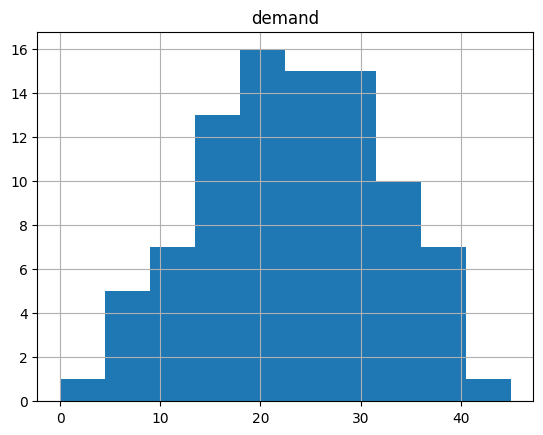

In [21]:
df_test.hist("demand")

In [22]:
df_test.to_csv("test.csv", index=False)

In [23]:
df_test_2.to_csv("test_2.csv", index=False)